In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
sns.set_style("white")
%matplotlib inline

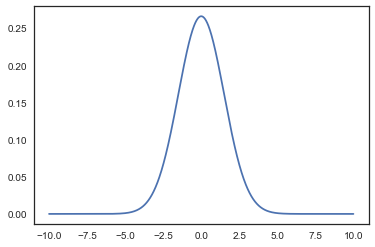

In [2]:
x = np.linspace(start=-10, stop=10, num=1000)

y = stats.norm.pdf(x, loc=0, scale=1.5)

plt.plot(x,y)

In [3]:
df = pd.read_csv('dataset/bimodal_example.csv')
df.head(n=5)

,x
0,0.252851
1,-1.034562
2,3.319558
3,4.552363
4,-0.775995


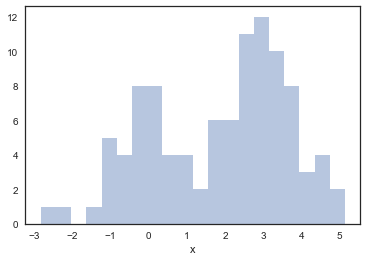

In [4]:
data = df.x
sns.distplot(data, bins=20, kde=False)

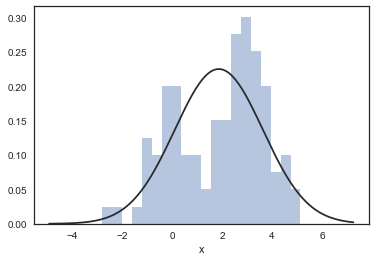

In [5]:
sns.distplot(data, fit=stats.norm, bins=20, kde=False)

In [6]:
class Gaussian:
    
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def pdf(self, datum):
        u = (datum - self.mu) /abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) *  exp(-u * u /2)
        return y
    
    def __repr__(self):
        return 'Gaussian ({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)
    

In [7]:
best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: u = {:.2}, sig= {:.2}'.format(best_single.mu, best_single.sigma))


Best single Gaussian: u = 1.9, sig= 1.8


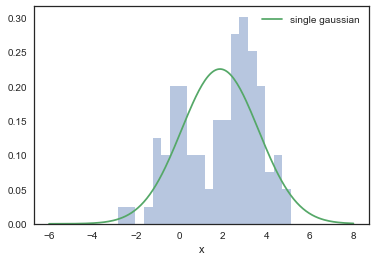

In [8]:
x = np.linspace(-6, 8 ,200)
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=20, kde=False, norm_hist=True)
plt.plot(x,  g_single, label='single gaussian')
plt.legend()

In [9]:
from math import exp ,sqrt ,log,pi
from random import uniform

In [10]:
class GaussianMixture:
    
    def __init__(self, data, mu_min= min(data) , mu_max=max(data), sigma_min=.1,sigma_max=1, mix=.5):
        
        self.data=data
        
        self.one = Gaussian(uniform(mu_min,mu_max), uniform(sigma_min,sigma_max))
        self.two = Gaussian(uniform(mu_min,mu_max), uniform(sigma_min,sigma_max))
        
        self.mix = mix
        
    def Estep(self):
        
        self.loglike = 0.
        
        for datum in self.data:
            
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1 - self.mix)
            
            den = wp1 + wp2
            
            wp1 /= den
            wp2 /= den
            
            self.loglike += log(wp1+wp2)
            
            yield(wp1, wp2)
            
    def Mstep(self, weights):
        
        (left,right) = zip(*weights)
        one_den = sum(left)
        two_den = sum(right)
        
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(right, data))
        
        self.one.sigma = sqrt( sum(w * ((d - self.one.mu)** 2) 
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt( sum(w * ((d - self.two.mu)** 2)
                                  for (w, d) in zip(right, data)) / two_den)
        
        self.mix = one_den / len(data)
        
    def iterate(self, N=1, verbose=False):
        ""
        for i in range(1, N+1):
            self.Mstep(self.Estep())
            if verbose:
                print('{0:2} {1}'.format(i, self))
                
            self.Estep()
    
    def pdf(self, x):
        return (self.mix) * self.one.pdf(x) + (1 - self.mix) *self.two.pdf(x)
    
    def __repr__(self):
        return 'GaussianMixture({0} , {1}, mix={2.03})'.format(self.one, self.two, self.mix)
    
    def __str__(self):
        return 'Mixture ({0} , {1}, mix={2:.03})'.format(self.one, self.two, self.mix)

In [11]:
n_iterations = 5
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture(data)

for _ in range(n_iterations):
    try:
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
            
            
    except (ZeroDivisionError, ValueError, RuntimeWarning):
        print("1")
        pass

 1 Mixture (Gaussian (-0.925063, 0.673441) , Gaussian (2.39957, 1.36574), mix=0.161)
 1 Mixture (Gaussian (-0.7281, 0.757299) , Gaussian (2.4191, 1.39021), mix=0.177)
 1 Mixture (Gaussian (-0.619279, 0.783921) , Gaussian (2.47552, 1.36359), mix=0.198)
 1 Mixture (Gaussian (-0.553821, 0.795897) , Gaussian (2.54426, 1.31437), mix=0.22)
 1 Mixture (Gaussian (-0.503944, 0.8026) , Gaussian (2.61757, 1.25365), mix=0.242)


In [12]:
n_iterations = 20
n_random_restarts = 500
best_mix = None
best_looklike = float('-inf')
print('computing best model wih random restart.....')


for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeError):
            pass
print("\n\n\nDone")

computing best model wih random restart.....


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars





Done


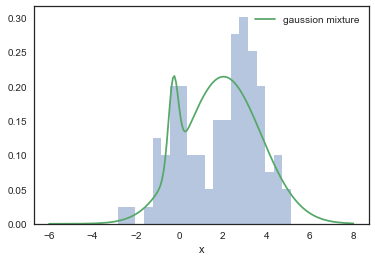

In [13]:
sns.distplot(data, bins=20, kde=False, norm_hist=True)
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x,  g_both, label="gaussion mixture")
plt.legend()